<a href="https://colab.research.google.com/github/tanishaaa15/CamoGAN-project/blob/main/CamoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt

# Load the dataset
(ds_train, ds_test,ds_val), ds_info = tfds.load(
    'cassava',
    split=['train[:60%]', 'train[60%:80%]','train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))  # Resize images to 128x128
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1] range
    return image, label

# Apply preprocessing
ds_train = ds_train.map(lambda img, lbl: preprocess(img, lbl)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(lambda img, lbl: preprocess(img, lbl)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(lambda img, lbl: preprocess(img, lbl)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

# Define the Generator Model
def build_generator():
    model = Sequential()
    model.add(Dense(16*16*256, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16, 16, 256)))

    # Conv2DTranspose blocks
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))

    # Final convolution to get the desired output shape
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

    return model

generator = build_generator()
generator.summary()
# Define the Discriminator Model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(128, 128, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             8454144   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 128)       524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 64)        131136    
 Transpose)                                             

In [ ]:
# GAN Model Definition
class CassavaGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images, _ = batch  # Unpack the images from the batch
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as d_tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.d_loss(labels, predictions)

        grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        misleading_labels = tf.zeros((batch_size, 1))
        with tf.GradientTape() as g_tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.g_loss(misleading_labels, predictions)

        grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# ModelMonitor Callback
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
import os
# Ensure the images directory exists
if not os.path.exists('images'):
    os.makedirs('images')

# Save the model after training in the .keras format
class ModelSaver(Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save(os.path.join('archive', 'generatormodel.keras'))
# Ensure the archive directory exists
if not os.path.exists('archive'):
    os.makedirs('archive')

Epoch 1/10
107/107 [==============================] - 822s 8s/step - d_loss: 0.4566 - g_loss: 3.4853
Epoch 2/10
107/107 [==============================] - 812s 8s/step - d_loss: 0.1732 - g_loss: 5.7591
Epoch 3/10
107/107 [==============================] - 817s 8s/step - d_loss: 0.2265 - g_loss: 5.2363
Epoch 4/10
107/107 [==============================] - 805s 8s/step - d_loss: 0.2341 - g_loss: 4.8114
Epoch 5/10
107/107 [==============================] - 805s 8s/step - d_loss: 0.2302 - g_loss: 6.2974
Epoch 6/10
107/107 [==============================] - 804s 8s/step - d_loss: 0.1626 - g_loss: 5.3157
Epoch 7/10
107/107 [==============================] - 804s 8s/step - d_loss: 0.1464 - g_loss: 5.8175
Epoch 8/10
107/107 [==============================] - 803s 8s/step - d_loss: 0.2148 - g_loss: 5.2526
Epoch 9/10
107/107 [==============================] - 811s 8s/step - d_loss: 0.2147 - g_loss: 5.2350
Epoch 10/10
107/107 [==============================] - 812s 8s/step - d_loss: 0.1497 - g_lo

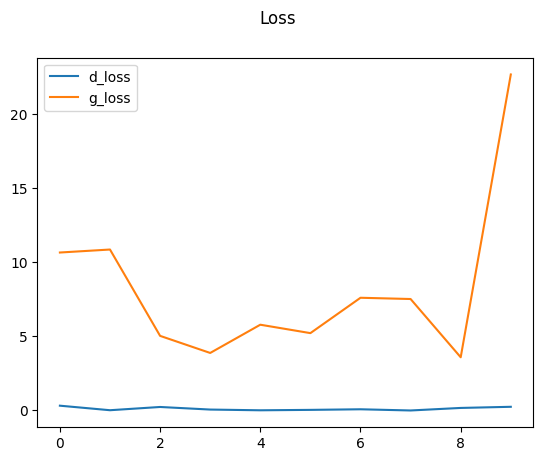

In [ ]:
cassava_gan = CassavaGAN(generator, discriminator)

g_opt = Adam(learning_rate=0.0001, beta_1=0.5)
d_opt = Adam(learning_rate=0.0004, beta_1=0.5)

cassava_gan.compile(
    g_opt=g_opt,
    d_opt=d_opt,
    g_loss=BinaryCrossentropy(),
    d_loss=BinaryCrossentropy()
)

# Train the GAN
hist = cassava_gan.fit(ds_train, epochs=10, callbacks=[ModelMonitor(), ModelSaver()])

# Plotting the graph
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 762ms/step


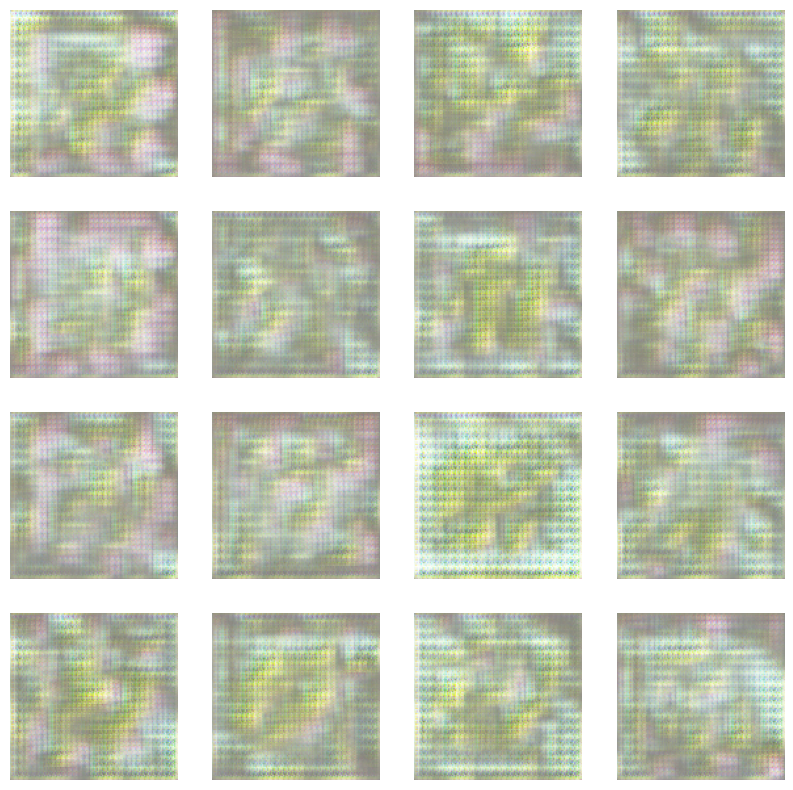

In [ ]:
# After training, test the generator
generator.load_weights(os.path.join('archive', 'generatormodel.keras'))
# Generate images using the generator
latent_dim = 128
num_images = 16  # Number of images to generate
noise = tf.random.normal((num_images, latent_dim))
generated_images = generator.predict(noise)

# Plot the generated images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for i in range(16):
    r = i // 4
    c = i % 4
    ax[r][c].imshow((generated_images[i] * 127.5 + 127.5).astype('uint8'))
    ax[r][c].axis('off')
plt.show()

In [ ]:
# Evaluate the discriminator on individual test images
results = []
for batch in ds_test:
    images, _ = batch
    predictions = discriminator.predict(images)
    results.extend(predictions)

# Print out results for individual images
for i, prediction in enumerate(results):
    print(f'Image {i+1}: Discriminator confidence that this image is real: {prediction[0]:.4f}')
latent_dim = 128
num_images = len(ds_test) * 32  # Assuming the test dataset is similar in size to the train dataset
noise = tf.random.normal((num_images, latent_dim))
generated_images = generator.predict(noise)

# Prepare the combined dataset for evaluation
real_images = []
for images, _ in ds_test:
    real_images.append(images)
real_images = tf.concat(real_images, axis=0)


1/1 [==============================] - 0s 342ms/step
Image 1: Discriminator confidence that this image is real: 0.6968
Image 2: Discriminator confidence that this image is real: 0.5421
Image 3: Discriminator confidence that this image is real: 0.4652
Image 4: Discriminator confidence that this image is real: 0.5984
Image 5: Discriminator confidence that this image is real: 0.6398
Image 6: Discriminator confidence that this image is real: 0.5807
Image 7: Discriminator confidence that this image is real: 0.4508
Image 8: Discriminator confidence that this image is real: 0.3360
Image 9: Discriminator confidence that this image is real: 0.4709
Image 10: Discriminator confidence that this image is real: 0.7482
Image 11: Discriminator confidence that this image is real: 0.4975
Image 12: Discriminator confidence that this image is real: 0.3197
Image 13: Discriminator confidence that this image is real: 0.4706
Image 14: Discriminator confidence that this image is real: 0.8123
Image 15: Discrimi

72/72 [==============================] - 1s 10ms/step - loss: 1.3030
Discriminator loss on the test set: 1.3030091524124146


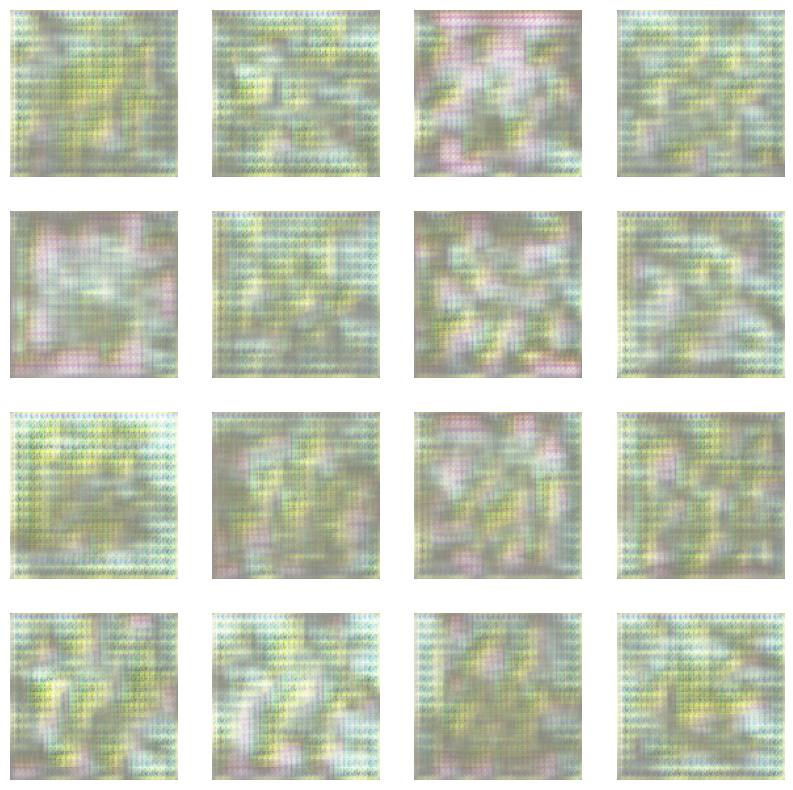

In [ ]:
# Create labels for real and fake images
real_labels = tf.ones((real_images.shape[0], 1))
fake_labels = tf.zeros((generated_images.shape[0], 1))

# Combine real and fake images
combined_images = tf.concat([real_images, generated_images], axis=0)
combined_labels = tf.concat([real_labels, fake_labels], axis=0)

# Compile the discriminator for evaluation
discriminator.compile(optimizer=d_opt, loss=tf.keras.losses.BinaryCrossentropy())

# Evaluate the discriminator on the combined dataset
d_loss = discriminator.evaluate(combined_images, combined_labels)
print(f'Discriminator loss on the test set: {d_loss}')

#  visualize some of the generated images:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for i in range(16):
    r = i // 4
    c = i % 4
    ax[r][c].imshow((generated_images[i] * 127.5 + 127.5).astype('uint8'))
    ax[r][c].axis('off')
plt.show()

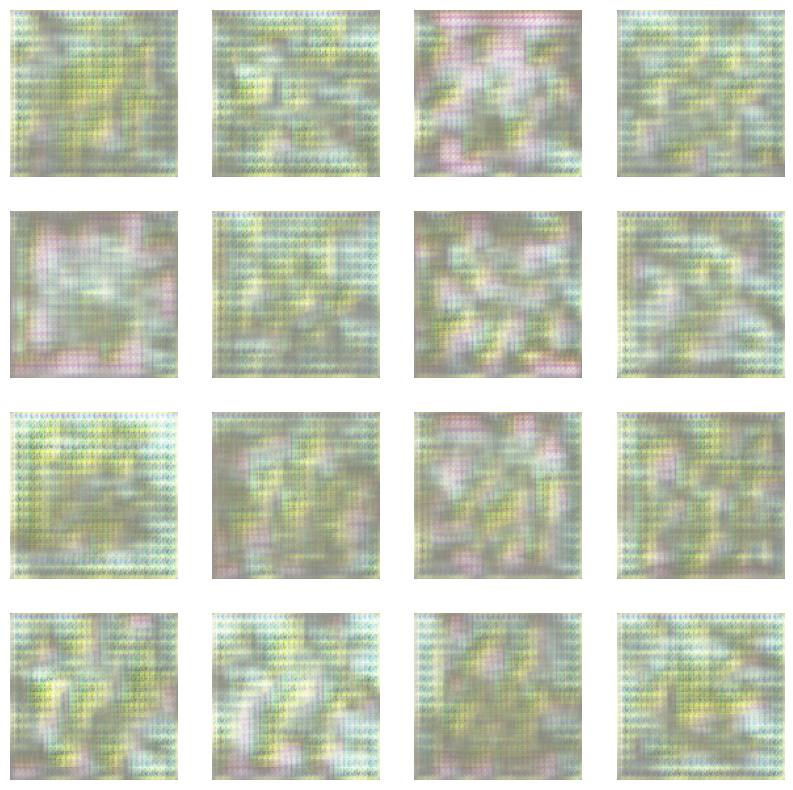

In [ ]:

# After training, test the generator
generator.load_weights(os.path.join('archive', 'generatormodel.keras'))

# Plot the generated images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for i in range(16):
    r = i // 4
    c = i % 4
    ax[r][c].imshow((generated_images[i] * 127.5 + 127.5).astype('uint8'))
    ax[r][c].axis('off')
plt.show()

In [ ]:
# Compile the discriminator for evaluation
discriminator.compile(optimizer=d_opt, loss=tf.keras.losses.BinaryCrossentropy())

# Evaluate the discriminator on individual test images
results = []
for batch in ds_test:
    images, labels = batch
    predictions = discriminator.predict(images)
    for image, prediction, label in zip(images, predictions, labels):
        results.append((image, prediction, label))

1/1 [==============================] - 0s 64ms/step


In [ ]:
# Print out results for individual images
for i, (image, prediction, label) in enumerate(results[:num_images]):
    print(f'Image {i+1}: Discriminator confidence that this image is real: {prediction[0]:.4f}, Label: {label.numpy()}')

# After training, test the generator
generator.load_weights(os.path.join('archive', 'generatormodel.keras'))

Image 1: Discriminator confidence that this image is real: 0.1062, Label: 2
Image 2: Discriminator confidence that this image is real: 0.8246, Label: 3
Image 3: Discriminator confidence that this image is real: 0.6167, Label: 3
Image 4: Discriminator confidence that this image is real: 0.4765, Label: 3
Image 5: Discriminator confidence that this image is real: 0.6014, Label: 4
Image 6: Discriminator confidence that this image is real: 0.5659, Label: 2
Image 7: Discriminator confidence that this image is real: 0.8506, Label: 1
Image 8: Discriminator confidence that this image is real: 0.4168, Label: 2
Image 9: Discriminator confidence that this image is real: 0.8452, Label: 1
Image 10: Discriminator confidence that this image is real: 0.3876, Label: 2
Image 11: Discriminator confidence that this image is real: 0.7547, Label: 3
Image 12: Discriminator confidence that this image is real: 0.5985, Label: 4
Image 13: Discriminator confidence that this image is real: 0.7714, Label: 4
Image 14

1/1 [==============================] - 0s 28ms/step


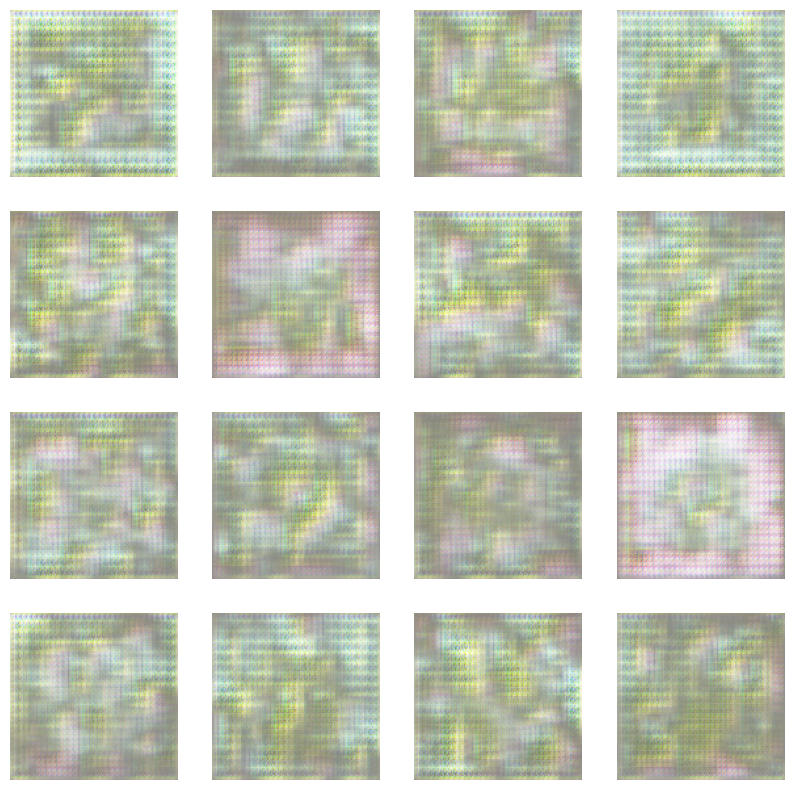

In [ ]:
# Generate images using the generator
latent_dim = 128
num_images = 16  # Number of images to generate
noise = tf.random.normal((num_images, latent_dim))
generated_images = generator.predict(noise)

# Plot the generated images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for i in range(16):
    r = i // 4
    c = i % 4
    ax[r][c].imshow((generated_images[i] * 127.5 + 127.5).astype('uint8'))
    ax[r][c].axis('off')
plt.show()

1/1 [==============================] - 0s 118ms/step


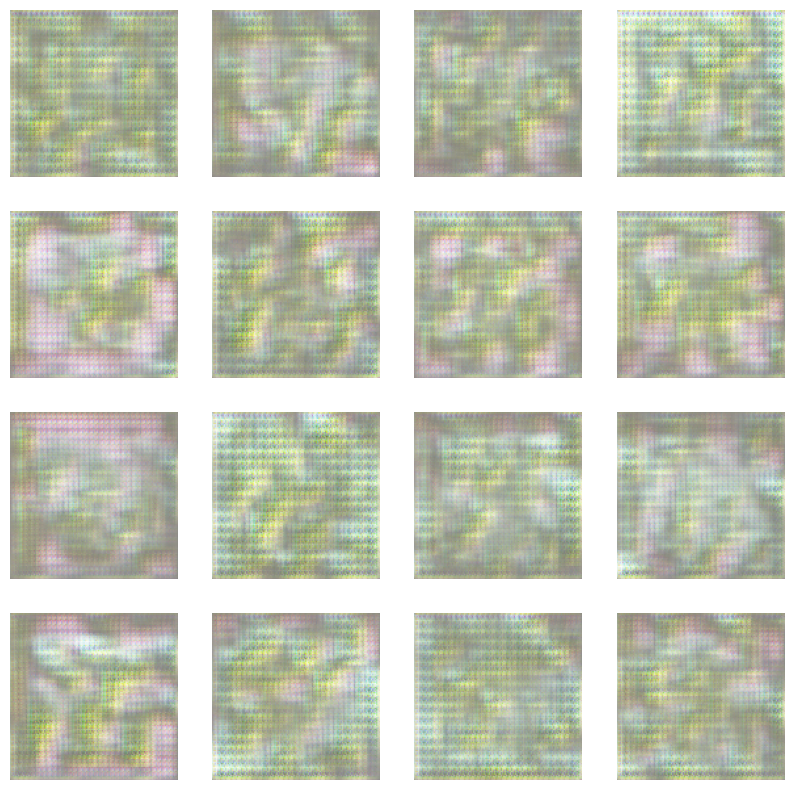

Val Discriminator Loss: 0.6921389698982239


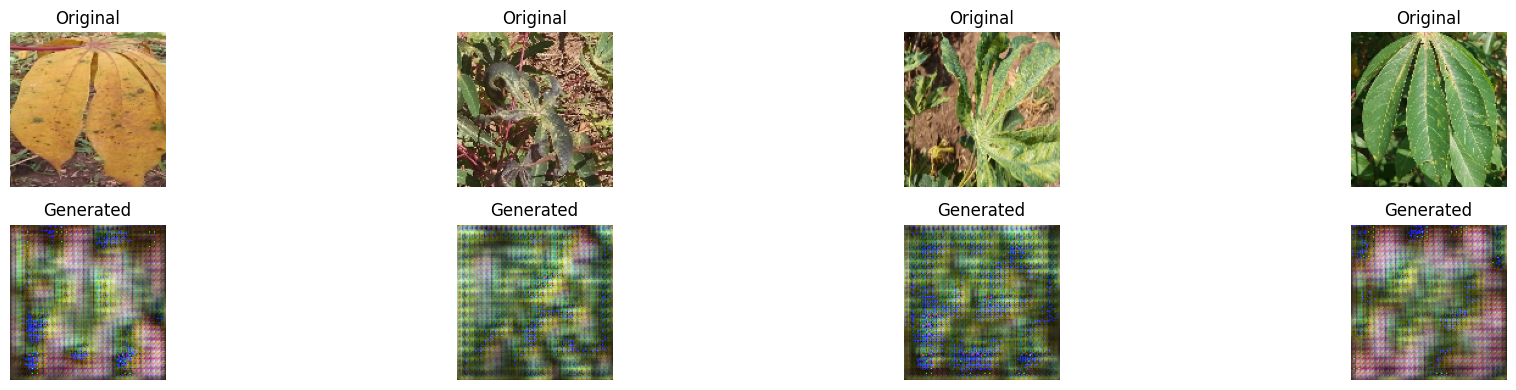

In [ ]:

# Load and preprocess the validation dataset
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

ds_val, ds_info = tfds.load('cassava', split='train[80%:]', as_supervised=True, with_info=True)
ds_val = ds_val.map(preprocess)
ds_val = ds_val.batch(4)

# Define the GAN model
class CassavaGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images, _ = batch  # Unpack the images from the batch
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as d_tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.d_loss(labels, predictions)

        grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        misleading_labels = tf.zeros((batch_size, 1))
        with tf.GradientTape() as g_tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.g_loss(misleading_labels, predictions)

        grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# ModelMonitor Callback
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

# ModelSaver Callback
class ModelSaver(Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save(os.path.join('archive', 'generatormodel.keras'))

# Function to plot generated images
def plot_generated_images(generator, latent_dim=128, num_images=16):
    noise = tf.random.normal((num_images, latent_dim))
    generated_images = generator.predict(noise)

    fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
    for i in range(16):
        r = i // 4
        c = i % 4
        ax[r][c].imshow((generated_images[i] * 127.5 + 127.5).astype('uint8'))
        ax[r][c].axis('off')
    plt.show()

# Evaluate the discriminator on the validation dataset
def evaluate_discriminator(discriminator, ds_val, generator, cassava_gan):
    val_loss = []

    for batch in ds_val:
        real_images, _ = batch
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))
        generated_images = generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        predictions = discriminator(combined_images)
        d_loss = cassava_gan.d_loss(labels, predictions)
        val_loss.append(d_loss.numpy())

    print(f'Val Discriminator Loss: {np.mean(val_loss)}')

# Plot original and generated images side by side
def plot_original_and_generated_images(ds_val, generator, latent_dim=128):
    for val_images, _ in ds_val.take(1):  # Take one batch of val images
        # Generate images using the generator
        latent_vectors = tf.random.normal((val_images.shape[0], latent_dim))
        generated_images = generator(latent_vectors)

        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 4))

        for i in range(val_images.shape[0]):
            # Original images
            axes[0, i].imshow(val_images[i].numpy())
            axes[0, i].axis('off')
            axes[0, i].set_title('Original')

            # Generated images
            gen_img = generated_images[i].numpy()
            gen_img = (gen_img * 255).astype(np.uint8)  # Convert to uint8
            axes[1, i].imshow(gen_img)
            axes[1, i].axis('off')
            axes[1, i].set_title('Generated')

        plt.tight_layout()
        plt.show()

generator = build_generator()
discriminator = build_discriminator()

# Compile the GAN model
g_opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)
g_loss = tf.keras.losses.BinaryCrossentropy()
d_loss = tf.keras.losses.BinaryCrossentropy()

cassava_gan = CassavaGAN(generator, discriminator)
cassava_gan.compile(g_opt, d_opt, g_loss, d_loss)

# Load the trained generator model
generator.load_weights(os.path.join('archive', 'generatormodel.keras'))

# Plot generated images
plot_generated_images(generator)

# Evaluate the discriminator
evaluate_discriminator(discriminator, ds_val, generator, cassava_gan)

# Plot original and generated images
plot_original_and_generated_images(ds_val, generator)

In [ ]:
import tensorflow_datasets as tfds

# Correctly load the dataset with appropriate splits
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cassava',
    split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Function to count the number of elements in a dataset split
def count_elements(ds):
    return sum(1 for _ in ds)

# Count the number of elements in each split
num_train = count_elements(ds_train)
num_val = count_elements(ds_val)
num_test = count_elements(ds_test)

# Get the total number of images in the dataset
total_images = ds_info.splits['train'].num_examples

print(f'Total number of images in the Cassava dataset: {total_images}')
print(f'Number of training images: {num_train}')
print(f'Number of validation images: {num_val}')
print(f'Number of test images: {num_test}')

Total number of images in the Cassava dataset: 5656
Number of training images: 3394
Number of validation images: 1131
Number of test images: 1131
